In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
%matplotlib inline

In [2]:
# initializing constants
K = 0.06    #liquid conductivity
s = 20.     #solid conductivity
a = 23300.  #area/volume
ac = 0.5    #alpha cathode
aa = 0.5    #alpha anode
io = 2e-7   #exchange current density
L = 1.      #length
n = 1       #exchanged electrons
F = 96485   #Faraday's constant
R = 8.314   #gas constant
T = 298     #temperature
I = 0.1     #total current density


#graph analytically
X = np.linspace(0., L, 100)
Y=y = X/L
v = L*np.sqrt(a*io*(n*F)/(R*T)*(K + s)/(K*s))
i2 = I * K/(K + s)*(1 + (s*(K**-1)*np.sinh(v*(1-y)) - np.sinh(v*y))/np.sinh(v))

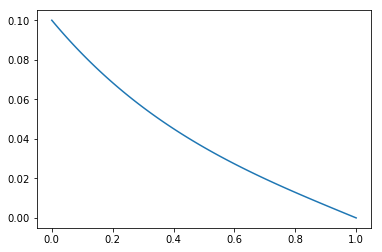

In [3]:
plt.plot(X, i2)

In [4]:
#solve numerically

#analytically combined equation
def simplebattfunc(i, x):
    i0, i1 = i
    di = i1
    d2i = a*io*(n*F)/(R*T)*(-I/s + i0*(1/s + 1/K))
    return di, d2i

#systems of differential equations with drop-in replacements possible
def linearbattfunc(IV, x):
    i1, i2, V1, V2 = IV
    di2 = a*io*(n*F)/(R*T)*(V1 - V2)
    di1 = -di2
    dV1 = -i1/s
    dV2 = -i2/K
    return di1, di2, dV1, dV2

def BVbattfunc(IV, x):
    i1, i2, V1, V2 = IV
    di2 = -a*io*np.exp((n*F)/(R*T)*-ac*(V1 - V2))
    di1 = -di2
    dV1 = -i1/s
    dV2 = -i2/K
    return di1, di2, dV1, dV2

In [5]:
def objective(u2_0):
    """
    The thing we want to set equal to zero
    """
    
    U = odeint(simplebattfunc, [I, u2_0], X)
    print(U[-1,0])
    return U[-1,0]


def objectiveLinear(V2o):
    """
    Shooting method for solving linear kinetic system
    """
    
    V = odeint(linearbattfunc, [0, I, 0, V2o], X)
    dV = np.diff(V[:,3])/np.diff(X)
    return dV[-1]


def objectiveBV(V2o):
    """
    Shooting method for solving Butler-Volmer kinetics system (Tafel)
    """
    
    V = odeint(BVbattfunc, [0, I, 0, V2o], X)
    dV = np.diff(V[:,3])/np.diff(X)
    print(dV[-1])
    return dV[-1]

0.29354480019
0.29354480019
0.29354480019
0.293544823854
1.19613405422e-09
-1.87657615142e-13
-1.66427185299
-1.66427185299
-1.66427185299
-1.66427185299
-1.66427185299
-1.66427185299
-1.66427185299
-1.66427185299
-1.66427185299
-1.66427185299
-1.66427185298
-1.66427185297
-1.66427185294
-1.66427185288


/Users/daltoncox/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


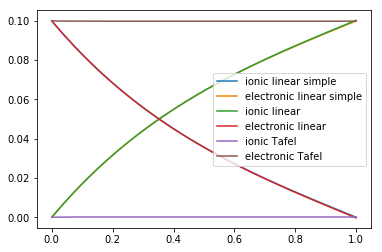

In [6]:
u2_0, = fsolve(objective, 0)
simple_i = odeint(simplebattfunc, [I, u2_0], X)
simple_i1 = I - simple_i[:,0]

u2_0, = fsolve(objectiveLinear, 0)
linear_IV = odeint(linearbattfunc, [0, I, 0, u2_0], X)

u2_0, = fsolve(objectiveBV, -1e-13)
BV_IV = odeint(BVbattfunc, [0, I, 0, u2_0], X)

plt.plot(X, simple_i[:,0], label = 'ionic linear simple')
plt.plot(X, simple_i1, label = 'electronic linear simple')
plt.plot(X, linear_IV[:,0], label = 'ionic linear')
plt.plot(X, linear_IV[:,1], label = 'electronic linear')
plt.plot(X, BV_IV[:,0], label = 'ionic Tafel')
plt.plot(X, BV_IV[:,1], label = 'electronic Tafel')
plt.legend(loc = 'best')

In [7]:
plt.plot?